In [1]:
import os
import netCDF4 as nc
import numpy as np
import pandas as pd
import xarray as xr
from datetime import datetime

import cartopy
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.mpl.ticker as cticker
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline
import cmocean

In [2]:
# constant declarations
#lat1 < lat2
lat1 = -45
lat2 = 45

#lon1 < lon2
lon1 = 0
lon2 = 360

lat_lims = [lat1,lat2]
lon_lims = [lon1,lon2]

#pressure level and month to access
pressure_level = 850
wind_pressure_level = 1000
month = 1


#variable files on disk
u_file = r'C:/Users/Jakidxav/Desktop/work_hartmann/erai_monthly/u/u.nc'
v_file = r'C:\Users\Jakidxav\Desktop\work_hartmann\erai_monthly\v\v.nc'
w_file = r'C:\Users\Jakidxav\Desktop\work_hartmann\erai_monthly\w\w.nc'

#constant accessor lists
month_list = ['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec']
lon_list = [90, 120, 150, 180, -150, -120, -90, -60, -30, 0, 30, 60, 90]
lat_list = [-30, 0, 30]


#for plotting
central_lon = -90

proj = ccrs.PlateCarree(central_longitude=central_lon)
trans = ccrs.PlateCarree()
stride = 3
colormap = cmocean.cm.balance
contours = 50

left_title = r'$\omega$ at '+str(pressure_level)
left_title_wind = r'$\omega$ at '+str(pressure_level)+'mb, u,v at '+str(wind_pressure_level)+'mb'
right_title = month_list[month-1].upper()

figure_name = 'w_'+str(pressure_level)+'_'+month_list[month-1]+'_mean.pdf'
figure_name_wind = 'w_'+str(pressure_level)+'_u_v_'+str(wind_pressure_level)+'_'+month_list[month-1]+'_mean.pdf'

# EDA

In [3]:
ds = xr.open_dataset(u_file)
u_data_df = ds.to_dataframe()

ds2 = xr.open_dataset(v_file)
v_data_df = ds2.to_dataframe()

In [4]:
u_data_df.reset_index(inplace=True)
v_data_df.reset_index(inplace=True)

In [5]:
u_data_df.head()

,latitude,levelist,longitude,time,u
0,90.0,1,0.0,1989-01-01,-33.369930
1,90.0,1,0.0,1989-02-01,1.279070
2,90.0,1,0.0,1989-03-01,-1.294518
3,90.0,1,0.0,1989-04-01,-0.124367
4,90.0,1,0.0,1989-05-01,-0.879780


In [6]:
v_data_df.head()

,latitude,levelist,longitude,time,v
0,90.0,1,0.0,1989-01-01,-6.275108
1,90.0,1,0.0,1989-02-01,4.190702
2,90.0,1,0.0,1989-03-01,-5.964535
3,90.0,1,0.0,1989-04-01,5.477361
4,90.0,1,0.0,1989-05-01,-0.265771


In [7]:
print(np.min(v_data_df.v))
print(np.max(v_data_df.v))
print(np.min(u_data_df.u))
print(np.max(u_data_df.u))

-82.0179
79.5095
-88.378
154.287


# Data Import

In [11]:
#read in data files
#u_data = nc.Dataset(u_file)
#v_data = nc.Dataset(v_file)
w_data = nc.Dataset(w_file)

In [12]:
#process w data
w = w_data.variables['w'][:]
lon  = w_data.variables['longitude'][:]
lat  = w_data.variables['latitude'][:]
dumb_time = w_data.variables['time'][:]
p = w_data.variables['levelist'][:]

In [10]:
u = u_data.variables['u'][:]
v = v_data.variables['v'][:]

In [13]:
time = pd.to_datetime(dumb_time, unit='h',
                       origin=pd.Timestamp('1900-01-01'))

#print(time)

AttributeError: module 'pandas' has no attribute 'to_datetime'

In [ ]:
print(time)

In [12]:
latidx = (lat >=lat_lims[0] ) & (lat <=lat_lims[1] )

lonidx = (lon >=lon_lims[0] ) & (lon <=lon_lims[1] )

timidx  = time.month == 1

pidx = (p==pressure_level)
wind_pidx = (p==wind_pressure_level)

In [13]:
print(wind_pidx)

[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
  True]


In [14]:
print(u.shape)
print(v.shape)
print(w.shape)

(228, 37, 121, 240)
(228, 37, 121, 240)
(228, 37, 121, 240)


In [15]:
u_time = u[timidx]
v_time = v[timidx]
w_time = w[timidx]

In [16]:
print(u_time.shape)
print(v_time.shape)
print(w_time.shape)

(19, 37, 121, 240)
(19, 37, 121, 240)
(19, 37, 121, 240)


In [17]:
u_time_p = u_time[:, wind_pidx, :, :]
v_time_p = v_time[:, wind_pidx, :, :]
w_time_p = w_time[:, pidx, :, :]

In [18]:
print(u_time_p.shape)
print(v_time_p.shape)
print(w_time_p.shape)

(19, 1, 121, 240)
(19, 1, 121, 240)
(19, 1, 121, 240)


In [19]:
u_time_p_lat = u_time_p[:, :, latidx, :]
v_time_p_lat = v_time_p[:, :, latidx, :]
w_time_p_lat = w_time_p[:, :, latidx, :]

In [20]:
print(u_time_p_lat.shape)
print(v_time_p_lat.shape)
print(w_time_p_lat.shape)

(19, 1, 61, 240)
(19, 1, 61, 240)
(19, 1, 61, 240)


In [32]:
u_month_avg = np.mean(u_time_p_lat, axis=0)
v_month_avg = np.mean(v_time_p_lat, axis=0)
w_month_avg = np.mean(w_time_p_lat, axis=0)

wind_x = u_month_avg[0]
wind_y = v_month_avg[0]
omega = w_month_avg[0]

In [22]:
print(u_month_avg.shape)
print(v_month_avg.shape)
print(w_month_avg.shape)

(1, 61, 240)
(1, 61, 240)
(1, 61, 240)


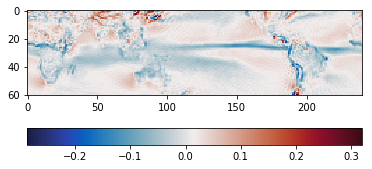

In [23]:
import matplotlib.cm as cm
plt.imshow(w_month_avg[0, :, :],cmap=cmocean.cm.balance)
plt.colorbar(orientation = 'horizontal')

In [24]:
print(lon[lonidx].shape)
print(lon[lonidx][::3].shape)

print(lat[latidx].shape)
print(lat[latidx][::3].shape)

print(u_month_avg[0][::3, ::3].shape)
print(v_month_avg[0][::3, ::3].shape)

(240,)
(80,)
(61,)
(21,)
(21, 80)
(21, 80)


## $\omega$ MAP

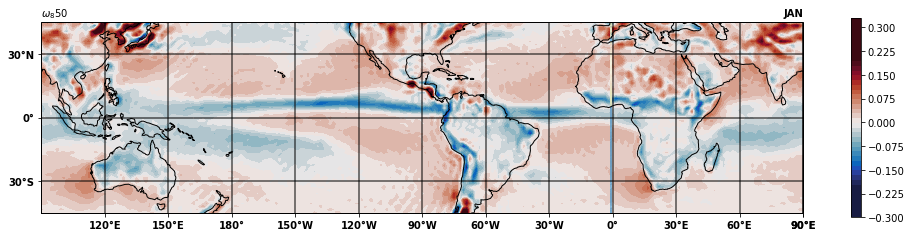

In [25]:
#without wind barbs
fig = plt.figure(figsize=(14, 28))
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=central_lon))

Norm = mpl.colors.Normalize(vmin=-.2,vmax=.2)
plt1 = plt.contourf(lon[lonidx], lat[latidx], w_month_avg[0], 50, transform=ccrs.PlateCarree(), cmap=cmocean.cm.balance, norm=Norm)

plt.colorbar(shrink=0.1, mappable=plt1)
ax.stock_img()
ax.coastlines()

ax.set_xticks(lon_list, crs=ccrs.PlateCarree())
ax.set_xticklabels(lon_list, weight='bold')
ax.set_yticks(lat_list, crs=ccrs.PlateCarree())
ax.set_yticklabels(lat_list, weight='bold')
ax.yaxis.tick_left()

lon_formatter = cticker.LongitudeFormatter()
lat_formatter = cticker.LatitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)
ax.grid(linewidth=2, color='black', alpha = 0.5)

left_title = r'$\omega$ at '+str(pressure_level)
right_title = month_list[month-1].upper()
figure_name = 'w_'+str(pressure_level)+'_'+month_list[month-1]+'_mean.pdf'

ax.set_title(r'$\omega_850$', loc='left', weight='semibold', size='medium')
ax.set_title(month_list[month-1].upper(), loc='right', weight='semibold', size='medium')

plt.savefig(figure_name, format='pdf')
plt.tight_layout()
plt.show()

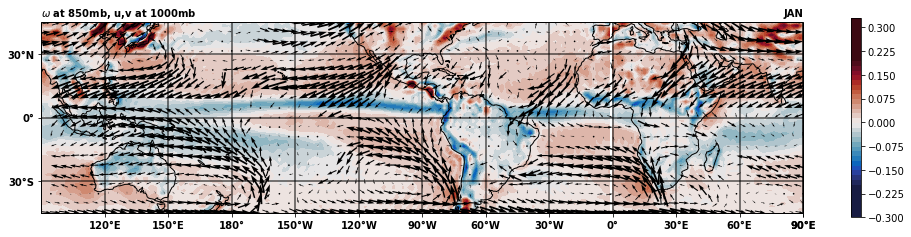

In [26]:
#with wind barbs
fig = plt.figure(figsize=(14, 28))
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=central_lon))


Norm = mpl.colors.Normalize(vmin=-.2, vmax=.2)
plt1 = plt.contourf(lon[lonidx], lat[latidx], w_month_avg[0], 50, transform=ccrs.PlateCarree(), cmap=cmocean.cm.balance, norm=Norm)
plt.colorbar(shrink=0.1, mappable=plt1)

#pivot : [ 'tail' | 'mid' | 'middle' | 'tip' ], default='tail'
q = ax.quiver(lon[lonidx][::3], lat[latidx][::3], u_month_avg[0][::3, ::3], v_month_avg[0][::3, ::3],
             minshaft=2, pivot='tip')

#ax.stock_img()
ax.coastlines()

ax.set_xticks(lon_list, crs=ccrs.PlateCarree())
ax.set_xticklabels(lon_list, weight='bold')
ax.set_yticks(lat_list, crs=ccrs.PlateCarree())
ax.set_yticklabels(lat_list, weight='bold')
ax.yaxis.tick_left()

lon_formatter = cticker.LongitudeFormatter()
lat_formatter = cticker.LatitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)
ax.grid(linewidth=2, color='black', alpha = 0.5)

left_title2 = r'$\omega$ at '+str(pressure_level)+'mb, u,v at '+str(wind_pressure_level)+'mb'
right_title = month_list[month-1].upper()
figure_name_wind = 'w_'+str(pressure_level)+'_u_v_'+str(wind_pressure_level)+'_'+month_list[month-1]+'_mean.pdf'

ax.set_title(left_title2, loc='left', weight='semibold', size='medium')
ax.set_title(right_title, loc='right', weight='semibold', size='medium')

plt.savefig(figure_name_wind, format='pdf')
plt.tight_layout()
plt.show()

In [27]:
print(r'$\omega$ at '+str(pressure_level)+'mb, u,v at '+str(wind_pressure_level)+'mb')

$\omega$ at 850mb, u,v at 1000mb


In [43]:
def plot_field(projection, central_lon, x, y, field, windx, windy, contours, transform, colormap, wind_vectors, strid, lon_list, lat_list,
               left_title, left_title_wind, right_title, figure_name, figure_name_wind, save_fig):
    fig = plt.figure(figsize=(14, 28))
    ax = plt.axes(projection=projection)


    Norm = mpl.colors.Normalize(vmin=-.2, vmax=.2)
    plt1 = plt.contourf(x, y, omega, contours, transform=proj, cmap=colormap, norm=Norm)
    plt.colorbar(shrink=0.1, mappable=plt1)
    
    if(wind_vectors==True):
        q = ax.quiver(x[::stride], y[::stride], wind_x[::stride, ::stride], wind_y[::stride, ::stride],
             minshaft=2, pivot='tip')
        
    ax.coastlines()

    ax.set_xticks(lon_list, crs=trans)
    ax.set_xticklabels(lon_list, weight='bold')
    ax.set_yticks(lat_list, crs=trans)
    ax.set_yticklabels(lat_list, weight='bold')
    ax.yaxis.tick_left()
    
    lon_formatter = cticker.LongitudeFormatter()
    lat_formatter = cticker.LatitudeFormatter()
    ax.xaxis.set_major_formatter(lon_formatter)
    ax.yaxis.set_major_formatter(lat_formatter)
    ax.grid(linewidth=2, color='black', alpha = 0.5)
    
    if(wind_vectors==True):
        ax.set_title(left_title_wind, loc='left', weight='semibold', size='medium')
    else:
        ax.set_title(left_title, loc='left', weight='semibold', size='medium')
    
    ax.set_title(right_title, loc='right', weight='semibold', size='medium')

    if(save_fig==True):
        if(wind_vectors==True):
            plt.savefig(figure_name_wind, format='pdf')
        else:
            plt.savefig(figure_name, format='pdf')
            
    plt.tight_layout()
    plt.show()

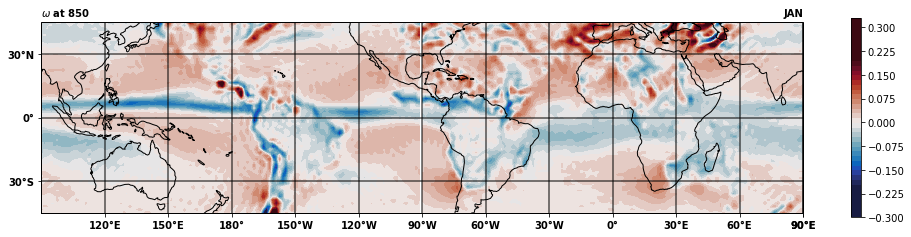

In [44]:
#without wind barbs
plot_field(proj, central_lon, lon[lonidx], lat[latidx], omega, wind_x, wind_y, contours, trans, colormap, False, stride, lon_list, lat_list,
               left_title, left_title_wind, right_title, figure_name, figure_name_wind, False)

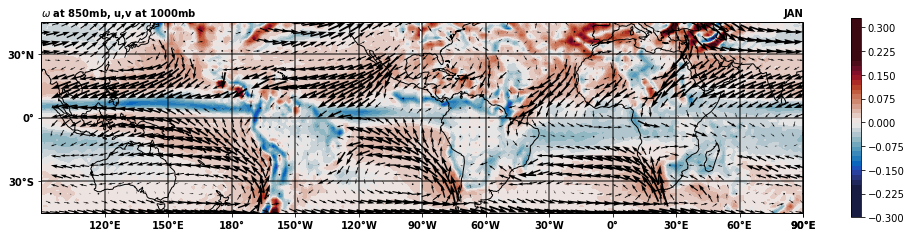

In [46]:
#with wind barbs
plot_field(proj, central_lon, lon[lonidx], lat[latidx], omega, wind_x, wind_y, contours, trans, colormap, True, stride, lon_list, lat_list,
               left_title, left_title_wind, right_title, figure_name, figure_name_wind, True)